# Tools

In [1]:
import tabulate

def instrument_info_table(instrument, *properties):
    data = [['name', instrument.name]]
    for p in properties:
        data.append([p, instrument.get(p)])
    return tabulate.tabulate(data, tablefmt='html')
    
signalcore_info = lambda ins: instrument_info_table(
    ins, 'frequency', 'power', 'output_status', 'temperature', 'reference_source',
) 

# Load instruments

In [2]:
### basic init and get the important instruments
from importlib import reload

from instrumentserver.client import Client
from labcore.setup import setup_opx_measurements
from labcore.setup.setup_opx_measurements import *

instruments = Client()
params = find_or_create_remote_instrument(instruments, 'parameter_manager')

# make sure you specify the correct IP and port for your OPX system.
import qmcfg; reload(qmcfg)
qm_config = qmcfg.QMConfig(params, '128.174.248.249', '80')

# these need to be specified so all measurement code is configured correctly
setup_opx_measurements.options.instrument_clients = {'instruments': instruments}
setup_opx_measurements.options.parameters = params
setup_opx_measurements.options.qm_config = qm_config

[2022-12-05 13:05:15.953] [root: INFO] Logging set up for <RootLogger root (INFO)>.
[2022-12-05 13:05:15.954] [instrumentserver.client.core: INFO] Connecting to tcp://localhost:5555


## Hardware

In [23]:
### load spike -- running remotely on a windows laptop
spike = find_or_create_remote_instrument(
    cli=instruments,
    ins_name='spike',
    ins_class='tfe_hardware.qcodes_instrument_drivers.SignalHound.Spike.Spike',
    address='TCPIP::192.168.1.202::5025::SOCKET'
)

### Generators

#### readout generator

In [3]:
### the various microwave generators
readout_generator = find_or_create_remote_instrument(
    cli=instruments,
    ins_name='readout_generator',
    ins_class='tfe_hardware.qcodes_instrument_drivers.SignalCore.SignalCore_sc5511a.SignalCore_SC5511A',
    serial_number='10002615',
)
signalcore_info(readout_generator)

name,readout_generator
frequency,7219500000.0
power,4.0
output_status,1
temperature,31.09375
reference_source,1


#### qubit generator

In [ ]:
qubit_generator = find_or_create_remote_instrument(
    cli=instruments,
    ins_name='qubit_generator',
    ins_class='tfe_hardware.qcodes_instrument_drivers.SignalCore.SignalCore_sc5511a.SignalCore_SC5511A',
    serial_number='10002613',
)
signalcore_info(qubit_generator)

#### TWPA pump generator

In [42]:
twpa_generator = find_or_create_remote_instrument(
    cli=instruments,
    ins_name='twpa_generator',
    ins_class='tfe_hardware.qcodes_instrument_drivers.SignalCore.SignalCore_sc5511a.SignalCore_SC5511A',
    serial_number='1000261D',
)
signalcore_info(twpa_generator)

name,twpa_generator
frequency,8000000000.0
power,3.0
output_status,0
temperature,74.875
reference_source,1


## Mixer configuration

### readout mixer

#### mixer setup and manual tuning tool

This snipped will create a mixer object that allows us to do most things.
It'll also run a constant tone and display a simple widget for messing with the mixer settings.
By looking at the spectrum we can manually tune the mixer with this.

In [51]:
readout_mixer = add_mixer_config('readout', analyzer=spike, generator=readout_generator)
readout_mixer.run_constant_waveform()
mixer_tuning_tool(readout_mixer)

[2022-12-05 16:04:46.740] [qm: INFO] Performing health check
[2022-12-05 16:04:46.743] [qm: INFO] Health check passed
[2022-12-05 16:04:46.759] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 16:04:46.768] [qm: INFO] Performing health check
[2022-12-05 16:04:46.771] [qm: INFO] Health check passed
[2022-12-05 16:04:47.026] [qm: INFO] Flags: 
[2022-12-05 16:04:47.026] [qm: INFO] Sending program to QOP
[2022-12-05 16:04:47.049] [qm: INFO] Executing program


#### Mixer optimization

In [ ]:
calibrate_mixer(readout_mixer.config)

### qubit mixer

#### mixer setup and manual tuning tool

This snipped will create a mixer object that allows us to do most things.
It'll also run a constant tone and display a simple widget for messing with the mixer settings.
By looking at the spectrum we can manually tune the mixer with this.

In [ ]:
qubit_mixer = add_mixer_config('qubit', analyzer=spike, generator=qubit_generator)
qubit_mixer.run_constant_waveform()
mixer_tuning_tool(qubit_mixer)

#### Mixer optimization

In [ ]:
calibrate_mixer(qubit.config)

# Test demodulation of readout signal

In [72]:
from qm.qua import *
from labcore.measurement import independent
from qcuiuc_measurement.opx_tools.sweep import \
    RecordOPXdata, ComplexOPXData, TimedOPXData

@RecordOPXdata(
    independent('repetition'),
    TimedOPXData('raw_signal', depends_on=['repetition']),
    TimedOPXData('I', depends_on=['repetition']),
    TimedOPXData('Q', depends_on=['repetition']),
)
def simple_demod(n_reps=10, rep_delay_ns=0):
    _chunksize = int(20 // 4)
    _n_chunks = params.readout.short.len() // (4 * _chunksize)
    
    with program() as raw_measurement:
        rep_stream = declare_stream()
        raw_stream = declare_stream(adc_trace=True)
        i_stream = declare_stream()
        q_stream = declare_stream()

        rep = declare(int)
        I = declare(fixed, size=_n_chunks)
        Q = declare(fixed, size=_n_chunks)
        j = declare(int)
    
        with for_(rep, 0, rep < n_reps, rep + 1):
            measure('readout_short', 'readout', raw_stream, 
                    demod.sliced("readout_short_sliced_cos", I, _chunksize),
                    demod.sliced("readout_short_sliced_sin", Q, _chunksize),)
            
            save(rep, rep_stream)
            
            with for_(j, 0, j < _n_chunks, j + 1):
                save(I[j], i_stream)
                save(Q[j], q_stream)
                
            if rep_delay_ns > 20:
                wait(int(rep_delay_ns)//4)

        with stream_processing():
            raw_stream.input1().save_all('raw_signal')
            rep_stream.save_all('repetition')
            i_stream.buffer(_n_chunks).save_all('I')
            q_stream.buffer(_n_chunks).save_all('Q')
            
    return raw_measurement


readout_generator.power(4.)
readout_generator.output_status(1)
readout_generator.frequency(params.readout.LO())

measurement = simple_demod(
    n_reps=100, 
    rep_delay_ns=1e4,
    collector_options=dict(batchsize=10),
)

data_loc, _ = run_measurement(sweep=measurement, name='test_through')

[2022-12-05 16:12:07.738] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T161207_db837402-test_through/data.ddh5
[2022-12-05 16:12:07.795] [qm: INFO] Performing health check
[2022-12-05 16:12:07.798] [qm: INFO] Health check passed
[2022-12-05 16:12:07.812] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 16:12:07.820] [qm: INFO] Performing health check
[2022-12-05 16:12:07.823] [qm: INFO] Health check passed
[2022-12-05 16:12:08.255] [qm: INFO] Flags: 
[2022-12-05 16:12:08.255] [qm: INFO] Sending program to QOP
[2022-12-05 16:12:08.517] [qm: INFO] Executing program
[2022-12-05 16:12:08.788] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 16:12:08.796] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T161207_db837402-test_

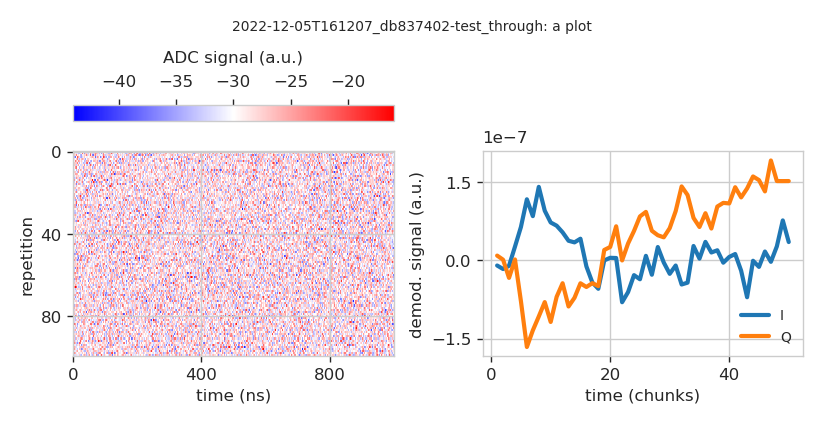

In [73]:
### using the DatasetAnalysis context helps us to load data easily, and automatically save plots in the right folder.

from qcuiuc_measurement.analysis.data import get_data, data_info, DatasetAnalysis
from qcuiuc_measurement.analysis.plotting import setup_plotting, format_ax, add_legend, ppcolormesh
from qcuiuc_measurement.setup_notebook_analysis import *

with DatasetAnalysis(data_loc) as analysis:
    i_data = analysis.get_data('I', avg_over='repetition')
    q_data = analysis.get_data('Q', avg_over='repetition')
    raw_data = analysis.get_data('raw_signal', avg_over=None)
    
    fig = analysis.make_figure('a plot', figsize=(4,2))
    
    # first subfig: plot the raw voltage as a colormap. We set the limits such that 0 is the middle.
    ax = fig.add_subplot(121)
    im = ax.imshow(
        raw_data.data_vals('raw_signal').T, 
        interpolation='none',
        cmap='bwr',
        aspect='auto',
    )
    format_ax(ax, xlabel='time (ns)', ylabel='repetition')
    cb = fig.colorbar(im, ax=ax, location='top')
    cb.set_label('ADC signal (a.u.)')
    
    # second subfig: plot one example trace of demodulated I and Q.
    ax = fig.add_subplot(122)
    ax.plot(i_data.data_vals('I_time_points'), i_data.data_vals('I'), '-',
            label='I')
    ax.plot(q_data.data_vals('Q_time_points'), q_data.data_vals('Q'), '-',
            label='Q')
    format_ax(ax, xlabel='time (chunks)', ylabel='demod. signal (a.u.)')
    ax.legend(loc='best')
    
    # this command saves the figures associated with the analysis in the data folder.
    analysis.save()